In [12]:
import torch

x = torch.tensor([0.9, 0.9, 0.1])

# Pad x with a zero at the beginning
x_padded = torch.cat([torch.zeros(1), x])
print(x_padded)
# Compute the cumulative product of (1 - x_padded[:-1]) and x
cumprod = torch.cumprod(1 - x_padded[:-1], dim=0)
print(cumprod)
result = x * cumprod

print(result)
print(0.2*0.9, (1-0.1-(0.2*0.9))*0.4)

tensor([0.0000, 0.9000, 0.9000, 0.1000])
tensor([1.0000, 0.1000, 0.0100])
tensor([0.9000, 0.0900, 0.0010])
0.18000000000000002 0.288


ray_directions.shape=torch.Size([900, 3])
camera_positions.shape=torch.Size([100, 3])
delta_forsamples.shape=torch.Size([3600, 1])
camera_positions.shape=torch.Size([100, 3])
camera_positions_forsamples.shape=torch.Size([3600, 3])
A.shape=torch.Size([28800, 3]) 7 -1
B.shape=torch.Size([9, 9, 9, 3])
selected_points_coords[100].shape=torch.Size([8, 3])
torch.Size([3600, 8, 3]) torch.Size([3600, 3])
temp.shape=torch.Size([32, 3])


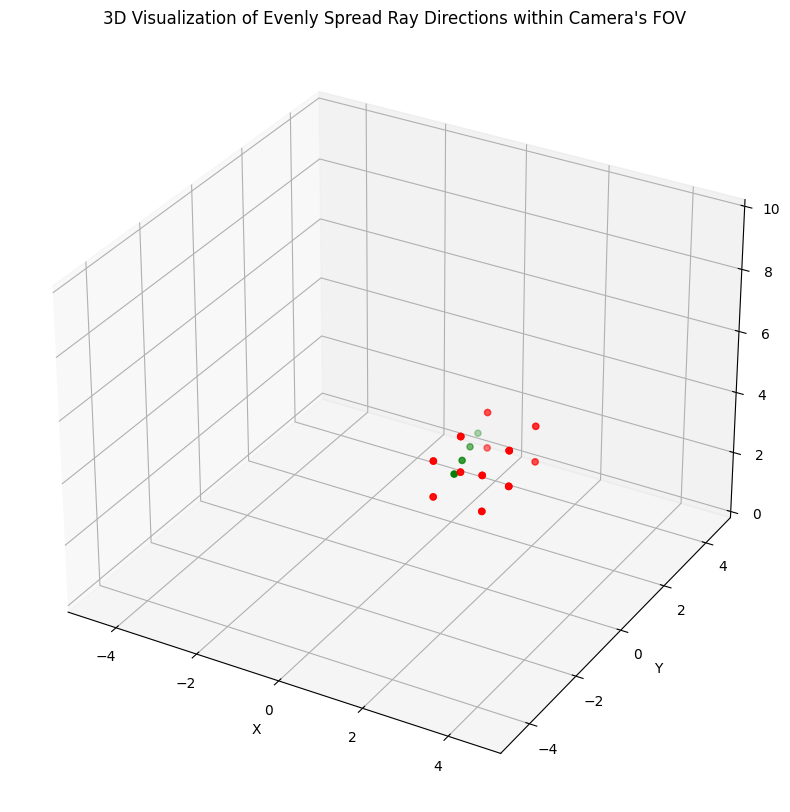

In [1207]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def get_points(grid_indices, samples_interval, points_distance):
    # (grid_indices - grid_indices.min(0)[0])/points_distance

    normalized_samples_for_indecies = ((samples_interval - grid_indices.min(0)[0])/points_distance)
    
    ceil_x = torch.ceil(normalized_samples_for_indecies[:,0]).unsqueeze(1)
    ceil_y = torch.ceil(normalized_samples_for_indecies[:,1]).unsqueeze(1)
    ceil_z = torch.ceil(normalized_samples_for_indecies[:,2]).unsqueeze(1)
    floor_x = torch.floor(normalized_samples_for_indecies[:,0]).unsqueeze(1)
    floor_y = torch.floor(normalized_samples_for_indecies[:,1]).unsqueeze(1)
    floor_z = torch.floor(normalized_samples_for_indecies[:,2]).unsqueeze(1)

    # generate the indecies of all the corners.
    relevant_points = [
        torch.cat([x_component, y_component, z_component], 1).unsqueeze(1)
        for x_component in [ceil_x, floor_x]
        for y_component in [ceil_y, floor_y]
        for z_component in [ceil_z, floor_z]
    ]
    relevant_points = torch.cat(relevant_points,1).type(torch.long)

    return relevant_points


def collect_cell_information_via_indices(A,B):
    # A = torch.tensor([[0, 1, 8]]*K)  # Shape: [K, 3]
    # B = torch.randn(X, Y, Z, N)  # Shape: [X, Y, Z, N]
    print(f"{A.shape=} {A.max()} {A.min()}\n{B.shape=}")

    X, Y, Z, N = B.shape

    
    # Define the desired column order
    column_order = torch.tensor([1, 0, 2])

    # Reorder the columns of A
    # A = torch.index_select(A, 1, column_order)
    

    # Reshape B to [X*Y*Z, N]
    B_flat = B.reshape(-1, N)  # Shape: [X*Y*Z, N]

    # Calculate flat indices from A
    indices = A[:, 0] * Y * Z + A[:, 1] * Z + A[:, 2]

    # Gather the elements from B_flat using the indices
    return torch.gather(B_flat, 0, indices.view(-1, 1).expand(-1, N))


def get_grid(sx, sy, sz, points_distance=0.5, info_size=3):
    
    grindx_indices,grindy_indices,grindz_indices = torch.arange(sx),torch.arange(sy),torch.arange(sz)

    coordsz, coordsx, coordsy = torch.meshgrid(grindz_indices,grindx_indices,grindy_indices, indexing='ij')

    meshgrid = torch.stack([coordsx, coordsy, coordsz]).T

    # center grid
    coordsx, coordsy, coordsz = coordsx - np.ceil(sx/2) + 1, coordsy - np.ceil(sy/2) + 1, coordsz - np.ceil(sz/2) + 1

    # edit grid spacing
    coordsx, coordsy, coordsz = coordsx*points_distance, coordsy*points_distance, coordsz*points_distance
    
    # make it so no points of the grid are underground
    coordsz = coordsz - coordsz.min() 
    
    grid_grid = torch.stack([coordsx, coordsy, coordsz]).T
    grid_coords = grid_grid.reshape(sx*sy*sz,3)

    # grid_cells = torch.zeros([grid_coords.shape[0], info_size])
    grid_cells = torch.zeros_like(grid_grid)

    return grid_coords, grid_cells, meshgrid, grid_grid

def find_points_in_voxel(samples, points):
    # Assuming you have the following tensors
    num_samples = 100
    num_points = 64
    samples = torch.randn(num_samples, 3)  # Replace with your samples tensor
    points = torch.randn(num_points, 3)    # Replace with your points tensor

    # Determine the voxel size
    min_coords, _ = torch.min(points, dim=0)
    max_coords, _ = torch.max(points, dim=0)
    voxel_size = (max_coords - min_coords) / (num_points - 1)

    # Normalize the samples
    normalized_samples = (samples - min_coords) / voxel_size

    # Calculate the voxel indices for each sample
    voxel_indices = torch.floor(normalized_samples).long()

    # Find the unique voxel indices
    unique_voxel_indices = torch.unique(voxel_indices, dim=0)

    # Calculate the corner points of the voxels
    unique_corner_points = unique_voxel_indices * voxel_size + min_coords

    return unique_corner_points, unique_voxel_indices


def find_closest_points(samples, points, N):
    num_samples = samples.size(0)
    num_points = points.size(0)

    # Expand both tensors to calculate pairwise distances
    samples_exp = samples.unsqueeze(1).expand(-1, num_points, -1)
    points_exp = points.unsqueeze(0).expand(num_samples, -1, -1)

    # Compute squared Euclidean distances
    dists = torch.sum((samples_exp - points_exp)**2, dim=2)

    # Find the indices of the N closest points
    _, indices = torch.topk(dists, N, dim=1, largest=False)

    # Get the N closest points for each sample
    closest_points = points[indices]

    return closest_points, indices

def get_data_from_index(data, index):
    camera_angle_x = data["camera_angle_x"]
    frame = data["frames"][index]

    file_path = frame["file_path"]
    rotation = frame["rotation"]
    transform_matrix = torch.tensor(frame["transform_matrix"])

    return transform_matrix, rotation, file_path, camera_angle_x


def generate_rays(num_rays, transform_matrix, camera_angle_x, even_spread=False):

    # Extract camera axes and position
    camera_x_axis = transform_matrix[:3, 0]
    camera_y_axis = transform_matrix[:3, 1]
    camera_z_axis = -transform_matrix[:3, 2]

    # Compute the aspect ratio (width / height) of the camera's FOV
    aspect_ratio = camera_x_axis.norm() / camera_y_axis.norm()

    # Generate evenly spread ray indices
    if even_spread:
        num_rays_sqrt = np.round(np.sqrt(num_rays))
        
        u_values = torch.linspace(-0.5 * camera_angle_x, 0.5 * camera_angle_x, int(num_rays_sqrt))
        v_values = torch.linspace(-0.5 * camera_angle_x / aspect_ratio, 0.5 * camera_angle_x / aspect_ratio, int(num_rays_sqrt))
        ray_indices = torch.cartesian_prod(u_values, v_values)
        
    else:
        # Generate random ray indices
        ray_indices = torch.rand(num_rays, 2)  # Generate random numbers in the range [0, 1)

        # Scale and shift the ray indices to match the camera's FOV
        ray_indices[:, 0] = camera_angle_x * (ray_indices[:, 0] - 0.5)
        ray_indices[:, 1] = camera_angle_x / aspect_ratio * (ray_indices[:, 1] - 0.5)

    # Get the u and v values from ray_indices
    u_values, v_values = ray_indices[:, 0].unsqueeze(-1), ray_indices[:, 1].unsqueeze(-1)
    directions = u_values * camera_x_axis + v_values * camera_y_axis + camera_z_axis
    
    ray_directions = directions / directions.norm(dim=1).unsqueeze(-1)

    return ray_directions

def get_camera_normal(transform_matrix):
    fixed_pos = transform_matrix[:3, :3].unsqueeze(0)
    fixed_pos[:,2] = fixed_pos[:,2]* -1
    return fixed_pos

def visulize_rays(ray_directions, camera_positions):

    # Orthographic projection: discard the z-coordinate
    ray_directions_2d = ray_directions[:, :2]

    # Plot the 2D vectors
    plt.figure(figsize=(10, 10))
    origin_x = camera_positions[:, 0]
    origin_y = camera_positions[:, 1]

    plt.quiver(origin_x, origin_y,
                ray_directions_2d[:, 0], ray_directions_2d[:, 1], angles='xy', scale_units='xy',
               scale=1)
    # plt.xlim(-2, 2)
    # plt.ylim(-2, 2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.title("Orthographic Projection of Evenly Spread Ray Directions within Camera's FOV")
    plt.grid()
    plt.show()

def visualize_rays_3d(ray_directions, camera_positions, red=None, green=None, orange=None):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')


    if len(camera_positions) > 0:
        origin_x = camera_positions[:, 0]
        origin_y = camera_positions[:, 1]
        origin_z = camera_positions[:, 2]

        # Plot 3D vectors
        for i in range(ray_directions.shape[0]):
            ax.quiver(origin_x[i], origin_y[i], origin_z[i],
                    ray_directions[i, 0], ray_directions[i, 1], ray_directions[i, 2],
                    color='b', alpha=0.5)

    for item, color in zip([red, green, orange], ['r','g','orange']):
        if not item is None:
            scatter_x = item[:, 0]
            scatter_y = item[:, 1]
            scatter_z = item[:, 2]
            ax.scatter(scatter_x, scatter_y, scatter_z, c=color, marker='o')
    
    ax.set_xlim3d(-5, 5)
    ax.set_ylim3d(-5, 5)
    ax.set_zlim3d(0, 5*2)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title("3D Visualization of Evenly Spread Ray Directions within Camera's FOV")
    plt.show()

def sample_camera_rays(data, number_of_rays, num_samples, delta_step, even_spread, camera_ray):

    if even_spread:
        number_of_rays = int(np.round(np.sqrt(number_of_rays))**2)

    ray_directions = torch.zeros([])
    camera_positions = torch.zeros([])
    for i in range(len(data["frames"])):
        transform_matrix, rotation, file_path, camera_angle_x = get_data_from_index(data, i)

        if camera_ray:
            current_ray_directions = transform_matrix[:3, 2].unsqueeze(0) * -1

        else:
            current_ray_directions = generate_rays(number_of_rays, transform_matrix, camera_angle_x, even_spread=even_spread)
            # current_ray_directions = generate_rays_batched(number_of_rays, transform_matrix.unsqueeze(0), camera_angle_x, even_spread=even_spread)[i]
            

        ray_directions = current_ray_directions if len(ray_directions.shape) == 0 else torch.cat(
            [ray_directions, current_ray_directions], 0)
        camera_positions = transform_matrix[:3, 3].unsqueeze(0) if len(camera_positions.shape) == 0 else torch.cat(
            [camera_positions, transform_matrix[:3, 3].unsqueeze(0)], 0)
        
    print(f"{ray_directions.shape=}")
    print(f"{camera_positions.shape=}")

    delta_forsamples = delta_step*torch.arange(num_samples + 1)[1:].repeat(number_of_rays * len(data["frames"]))\
        .unsqueeze(1)
    
    camera_positions_forsamples = torch.repeat_interleave(camera_positions, num_samples*number_of_rays, 0)

    ray_directions_forsamples = torch.repeat_interleave(ray_directions, num_samples, 0)
    samples_interval = camera_positions_forsamples + ray_directions_forsamples * delta_forsamples

    return samples_interval, camera_positions, ray_directions

# ---


number_of_rays=9
num_samples=4
delta_step=0.4
even_spread=True
camera_ray=False
points_distance = 1.2

data_folder = "D:\9.programming\Plenoxels\data"
object_folders = ['chair', 'drums', 'ficus', 'hotdog', 'lego', 'materials', 'mic', 'ship']

with open(f"{data_folder}/{object_folders[0]}/transforms_train.json", "r") as f:
    data = json.load(f)

samples_interval, camera_positions, ray_directions = sample_camera_rays_batched(data, 
                                                                        number_of_rays=number_of_rays, 
                                                                        num_samples=num_samples, 
                                                                        delta_step=delta_step, 
                                                                        even_spread=even_spread, 
                                                                        camera_ray=camera_ray
                                                                        )

grid_indices, grid_cells, meshgrid, grid_grid = get_grid(9, 9, 9, points_distance=1.2, info_size=4)

# visualize_rays_3d(ray_directions, camera_positions, grid_indices,samples_interval)


edge_matching_points = get_points(grid_indices, samples_interval, points_distance)
edge_matching_points = edge_matching_points.reshape([edge_matching_points.shape[0]*edge_matching_points.shape[1],edge_matching_points.shape[2]])
selected_points = collect_cell_information_via_indices(edge_matching_points, meshgrid)
selected_points_coords = selected_points*points_distance + grid_indices.min(0)[0]


selected_points = selected_points.view([int(selected_points.shape[0]/8),8,3])
selected_points_coords = selected_points_coords.view([int(selected_points_coords.shape[0]/8),8,3])
print(f"{selected_points_coords[100].shape=}")
print(selected_points.shape, samples_interval.shape)
# visualize_rays_3d(ray_directions, torch.repeat_interleave(camera_positions, 4, 0),grid_indices, samples_interval[0].unsqueeze(0))
# visualize_rays_3d(ray_directions, [],selected_points_coords[315], samples_interval[315].unsqueeze(0))
# visualize_rays_3d(ray_directions, [],selected_points_coords[55], samples_interval[55].unsqueeze(0))

temp = torch.cat([grid_grid[tuple(s.tolist())].unsqueeze(0) for s in selected_points[83]])
temp2 = samples_interval[83].unsqueeze(0)

index = 67
temp = torch.cat([grid_grid[tuple(s.tolist())].unsqueeze(0) for i in [index*num_samples+i for i in range(num_samples)] for s in selected_points[i] ])
temp2= torch.cat([samples_interval[i].unsqueeze(0) for i in [index*num_samples+i for i in range(num_samples)]],0)

print(f"{temp.shape=}")
# temp = torch.index_select(temp, 1, torch.tensor([1,0,2]))
visualize_rays_3d(ray_directions, [],temp, temp2)


# todo: 1. ~~create a function to denormalize the grid and use it. <- the one i use now is confirmed correct~~
# todo: 2. ~~check if torch.index_select at collect_cell_information_via_indices is nesscery. <- confirmed not~~
# todo: 3. debug and make modular. 

In [1217]:
meshgrid
grid_indices

tensor([[-4.8000, -4.8000,  0.0000],
        [-4.8000, -4.8000,  1.2000],
        [-4.8000, -4.8000,  2.4000],
        ...,
        [ 4.8000,  4.8000,  7.2000],
        [ 4.8000,  4.8000,  8.4000],
        [ 4.8000,  4.8000,  9.6000]])

In [1]:
[
    [x_component, y_component, z_component]
    for x_component in ["ceil_x", "floor_x"]
    for y_component in ["ceil_y", "floor_y"]
    for z_component in ["ceil_z", "floor_z"]
]

[['ceil_x', 'ceil_y', 'ceil_z'],
 ['ceil_x', 'ceil_y', 'floor_z'],
 ['ceil_x', 'floor_y', 'ceil_z'],
 ['ceil_x', 'floor_y', 'floor_z'],
 ['floor_x', 'ceil_y', 'ceil_z'],
 ['floor_x', 'ceil_y', 'floor_z'],
 ['floor_x', 'floor_y', 'ceil_z'],
 ['floor_x', 'floor_y', 'floor_z']]

In [1018]:
# torch.tensor([3,4,5]).unsqueeze(0).repeat([5,1])
# torch.linspace(-0.5 * camera_angle_x, 0.5 * camera_angle_x, int(num_rays_sqrt)).repeat([5,1])
aspect_ratio.shape[0]

100

In [1027]:



# torch.cartesian_prod(u_values[0], v_values[0]).shape

tensor([[-0.3456, -0.3456],
        [-0.3456,  0.0000],
        [-0.3456,  0.3456],
        [ 0.0000, -0.3456],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.3456],
        [ 0.3456, -0.3456],
        [ 0.3456,  0.0000],
        [ 0.3456,  0.3456]])

In [1030]:
# num_rays_sqrt = np.round(np.sqrt(number_of_rays))
# print(-0.5 * camera_angle_x / aspect_ratio, 0.5 * camera_angle_x / aspect_ratio, int(num_rays_sqrt))





# print(
#     u_values,
#     v_values
# )

print(ray_indices.shape)

torch.Size([100, 9, 2])


In [1144]:
def batched_cartesian_prod(A, B):
    A_expanded = A.unsqueeze(-1).expand(-1, -1, B.size(1))
    B_expanded = B.unsqueeze(-2).expand(-1, A.size(1), -1)
    return torch.stack((A_expanded, B_expanded), dim=-1).view(A.size(0), -1, 2)

def tensor_linspace(start, end, steps=10):
    """
    # https://github.com/zhaobozb/layout2im/blob/master/models/bilinear.py#L246

    Vectorized version of torch.linspace.
    Inputs:
    - start: Tensor of any shape
    - end: Tensor of the same shape as start
    - steps: Integer
    Returns:
    - out: Tensor of shape start.size() + (steps,), such that
      out.select(-1, 0) == start, out.select(-1, -1) == end,
      and the other elements of out linearly interpolate between
      start and end.
    """
    assert start.size() == end.size()
    view_size = start.size() + (1,)
    w_size = (1,) * start.dim() + (steps,)
    out_size = start.size() + (steps,)

    start_w = torch.linspace(1, 0, steps=steps).to(start)
    start_w = start_w.view(w_size).expand(out_size)
    end_w = torch.linspace(0, 1, steps=steps).to(start)
    end_w = end_w.view(w_size).expand(out_size)

    start = start.contiguous().view(view_size).expand(out_size)
    end = end.contiguous().view(view_size).expand(out_size)

    out = start_w * start + end_w * end
    return out

# tensor_linspace(torch.zeros(5), torch.ones(5), steps=10).shape
transform_matricies.shape[0]
number_of_rays


9

In [1183]:

# number_of_rays=number_of_rays
# num_samples=num_samples
# delta_step=delta_step
# even_spread=even_spread
# camera_ray=camera_ray
def generate_rays_batched(num_rays, transform_matrix, camera_angle_x, even_spread=False):

    transform_matricies, file_paths, camera_angle_x = preprocess_data(data)
    camera_x_axis = transform_matricies[:,:3, 0]
    camera_y_axis = transform_matricies[:, :3, 1]
    camera_z_axis = -transform_matricies[:, :3, 2]
    aspect_ratio = camera_x_axis.norm(dim=1) / camera_y_axis.norm(dim=1)
    even_spread = True
    if even_spread:
        num_rays_sqrt = np.round(np.sqrt(number_of_rays))
        
        start = torch.tensor([-0.5 * camera_angle_x]).repeat(aspect_ratio.shape)
        u_values = torch.linspace(-0.5 * camera_angle_x, 0.5 * camera_angle_x, int(num_rays_sqrt)).unsqueeze(0).repeat([aspect_ratio.shape[0],1])
        v_values = tensor_linspace(start / aspect_ratio, -start / aspect_ratio, int(num_rays_sqrt))
        ray_indices = batched_cartesian_prod(u_values, v_values)
        
    else:
        # Generate random ray indices
        ray_indices = torch.rand(transform_matricies.shape[0], number_of_rays, 2)  # Generate random numbers in the range [0, 1)

        # Scale and shift the ray indices to match the camera's FOV
        ray_indices[:,:,0] = camera_angle_x * (ray_indices[:,:,0] - 0.5)
        ray_indices[:,:,1] = ((camera_angle_x*(1/aspect_ratio)).unsqueeze(1)*(ray_indices[:,:, 1] - 0.5))



    # Get the u and v values from ray_indices
    u_values, v_values = ray_indices[:, :, 0].unsqueeze(-1), ray_indices[:, :, 1].unsqueeze(-1)
    u_values = u_values.expand(100, 9, 3)
    v_values = v_values.expand(100, 9, 3)

    camera_x_axis = camera_x_axis.unsqueeze(1).expand(100, 9, 3)
    camera_y_axis = camera_y_axis.unsqueeze(1).expand(100, 9, 3)
    camera_z_axis = camera_z_axis.unsqueeze(1).expand(100, 9, 3)

    directions = u_values * camera_x_axis + v_values * camera_y_axis + camera_z_axis

    ray_directions = directions/ directions.norm(dim=2).unsqueeze(-1)

    return ray_directions


torch.Size([100, 9, 1]) torch.Size([100, 9, 1]) torch.Size([100, 3, 1])
torch.Size([100, 9, 3]) torch.Size([100, 9, 1])



torch.Size([100, 9, 3])

In [1155]:
import torch

# Create example tensors
A = torch.rand(100, 9, 1)
B = torch.rand(100, 3)

# Expand both tensors
A_expanded = A.expand(100, 9, 3)
B_expanded = B.unsqueeze(1).expand(100, 9, 3)

# Perform element-wise multiplication
C = A_expanded * B_expanded

print(C.shape)  # Output: torch.Size([100, 9, 3])


torch.Size([100, 9, 3])


In [1161]:
A[3]*B[3]

tensor([[0.0248, 0.1238, 0.0089],
        [0.0558, 0.2784, 0.0199],
        [0.0327, 0.1632, 0.0117],
        [0.0172, 0.0860, 0.0062],
        [0.0542, 0.2705, 0.0194],
        [0.0594, 0.2965, 0.0212],
        [0.0711, 0.3545, 0.0254],
        [0.0436, 0.2176, 0.0156],
        [0.0387, 0.1930, 0.0138]])

In [1162]:
C[3]

tensor([[0.0248, 0.1238, 0.0089],
        [0.0558, 0.2784, 0.0199],
        [0.0327, 0.1632, 0.0117],
        [0.0172, 0.0860, 0.0062],
        [0.0542, 0.2705, 0.0194],
        [0.0594, 0.2965, 0.0212],
        [0.0711, 0.3545, 0.0254],
        [0.0436, 0.2176, 0.0156],
        [0.0387, 0.1930, 0.0138]])

In [1206]:
def preprocess_data(data):
    transform_matricies = []
    file_paths = []
    for i in range(len(data["frames"])):
        
        transform_matrix, rotation, file_path, camera_angle_x = get_data_from_index(data, i)
        transform_matricies.append(transform_matrix.unsqueeze(0))
        file_paths.append(file_path)

    transform_matricies = torch.cat(transform_matricies, 0)

    return transform_matricies, file_paths, camera_angle_x
    

def sample_camera_rays_batched(data, number_of_rays, num_samples, delta_step, even_spread, camera_ray):

    if even_spread:
        number_of_rays = int(np.round(np.sqrt(number_of_rays))**2)

    transform_matricies, file_paths, camera_angle_x = preprocess_data(data)

    ray_directions = torch.zeros([])
    camera_positions = torch.zeros([])

    if camera_ray:
        current_ray_directions = transform_matricies[:, :3, 2].unsqueeze(0) * -1

    else:
        current_ray_directions = generate_rays_batched(number_of_rays, transform_matricies, camera_angle_x, even_spread=even_spread)

    ray_directions = current_ray_directions
    camera_positions = transform_matricies[:, :3, 3]

    print(f"{ray_directions.shape=}")
    print(f"{camera_positions.shape=}")
    # ray_directions = current_ray_directions if len(ray_directions.shape) == 0 else torch.cat(
    #     [ray_directions, current_ray_directions], 0)
    # camera_positions = transform_matricies[:, :3, 3].unsqueeze(0) if len(camera_positions.shape) == 0 else torch.cat(
    #     [camera_positions, transform_matricies[:, :3, 3].unsqueeze(0)], 0)

    delta_forsamples = delta_step*torch.arange(num_samples + 1)[1:].repeat(number_of_rays * len(data["frames"]))\
        .unsqueeze(1)
    
    print(f"{delta_forsamples.shape=}")
    print(f"{camera_positions.shape=}")
    camera_positions_forsamples = torch.repeat_interleave(camera_positions, num_samples*number_of_rays, 0)
    print(f"{camera_positions_forsamples.shape=}")


    ray_directions_forsamples = torch.repeat_interleave(ray_directions, num_samples, 0)
    samples_interval = camera_positions_forsamples + ray_directions_forsamples * delta_forsamples

    return samples_interval, camera_positions, ray_directions


def generate_rays_batched(number_of_rays, transform_matricies, camera_angle_x, even_spread=False):

    # transform_matricies, file_paths, camera_angle_x = preprocess_data(data)
    camera_x_axis = transform_matricies[:,:3, 0]
    camera_y_axis = transform_matricies[:, :3, 1]
    camera_z_axis = -transform_matricies[:, :3, 2]
    aspect_ratio = camera_x_axis.norm(dim=1) / camera_y_axis.norm(dim=1)
    even_spread = True
    if even_spread:
        num_rays_sqrt = np.round(np.sqrt(number_of_rays))
        
        start = torch.tensor([-0.5 * camera_angle_x]).repeat(aspect_ratio.shape)
        u_values = torch.linspace(-0.5 * camera_angle_x, 0.5 * camera_angle_x, int(num_rays_sqrt)).unsqueeze(0).repeat([aspect_ratio.shape[0],1])
        v_values = tensor_linspace(start / aspect_ratio, -start / aspect_ratio, int(num_rays_sqrt))
        ray_indices = batched_cartesian_prod(u_values, v_values)
        
    else:
        # Generate random ray indices
        ray_indices = torch.rand(transform_matricies.shape[0], number_of_rays, 2)  # Generate random numbers in the range [0, 1)

        # Scale and shift the ray indices to match the camera's FOV
        ray_indices[:,:,0] = camera_angle_x * (ray_indices[:,:,0] - 0.5)
        ray_indices[:,:,1] = ((camera_angle_x*(1/aspect_ratio)).unsqueeze(1)*(ray_indices[:,:, 1] - 0.5))

    # Get the u and v values from ray_indices
    u_values, v_values = ray_indices[:, :, 0].unsqueeze(-1), ray_indices[:, :, 1].unsqueeze(-1)
    u_values = u_values.expand(100, 9, 3)
    v_values = v_values.expand(100, 9, 3)

    camera_x_axis = camera_x_axis.unsqueeze(1).expand(100, 9, 3)
    camera_y_axis = camera_y_axis.unsqueeze(1).expand(100, 9, 3)
    camera_z_axis = camera_z_axis.unsqueeze(1).expand(100, 9, 3)

    directions = u_values * camera_x_axis + v_values * camera_y_axis + camera_z_axis

    ray_directions = directions/ directions.norm(dim=2).unsqueeze(-1)

    return ray_directions.reshape(ray_directions.shape[0]*number_of_rays,-1)

def generate_rays(num_rays, transform_matrix, camera_angle_x, even_spread=False):

    # Extract camera axes and position
    camera_x_axis = transform_matrix[:3, 0]
    camera_y_axis = transform_matrix[:3, 1]
    camera_z_axis = -transform_matrix[:3, 2]

    # Compute the aspect ratio (width / height) of the camera's FOV
    aspect_ratio = camera_x_axis.norm() / camera_y_axis.norm()

    # Generate evenly spread ray indices
    if even_spread:
        num_rays_sqrt = np.round(np.sqrt(num_rays))
        
        u_values = torch.linspace(-0.5 * camera_angle_x, 0.5 * camera_angle_x, int(num_rays_sqrt))
        v_values = torch.linspace(-0.5 * camera_angle_x / aspect_ratio, 0.5 * camera_angle_x / aspect_ratio, int(num_rays_sqrt))
        ray_indices = torch.cartesian_prod(u_values, v_values)
        
    else:
        # Generate random ray indices
        ray_indices = torch.rand(num_rays, 2)  # Generate random numbers in the range [0, 1)

        # Scale and shift the ray indices to match the camera's FOV
        ray_indices[:, 0] = camera_angle_x * (ray_indices[:, 0] - 0.5)
        ray_indices[:, 1] = camera_angle_x / aspect_ratio * (ray_indices[:, 1] - 0.5)

    # Get the u and v values from ray_indices
    u_values, v_values = ray_indices[:, 0].unsqueeze(-1), ray_indices[:, 1].unsqueeze(-1)
    directions = u_values * camera_x_axis + v_values * camera_y_axis + camera_z_axis
    # print(u_values.shape, v_values.shape, camera_x_axis.shape, (u_values * camera_x_axis).shape)
    # print(directions.shape, directions.norm(dim=1).shape)
    ray_directions = directions / directions.norm(dim=1).unsqueeze(-1)

    return ray_directions


# samples_interval, camera_positions, ray_directions = sample_camera_rays(data, 
#                                                                         number_of_rays=number_of_rays, 
#                                                                         num_samples=num_samples, 
#                                                                         delta_step=delta_step, 
#                                                                         even_spread=even_spread, 
#                                                                         camera_ray=camera_ray
#                                                                         )


samples_interval_batched, camera_positions_batched, ray_directions_batched = sample_camera_rays_batched(data, 
                                                                        number_of_rays=number_of_rays, 
                                                                        num_samples=num_samples, 
                                                                        delta_step=delta_step, 
                                                                        even_spread=even_spread, 
                                                                        camera_ray=camera_ray
                                                                        )

ray_directions.shape=torch.Size([900, 3])
camera_positions.shape=torch.Size([100, 3])
delta_forsamples.shape=torch.Size([3600, 1])
camera_positions.shape=torch.Size([100, 3])
camera_positions_forsamples.shape=torch.Size([3600, 3])


In [865]:
torch.cat([grid_grid[tuple(s.tolist())].unsqueeze(0) for i in [80,81,82,83,84,85,86,87] for s in selected_points[i] ])
torch.cat([samples_interval[i].unsqueeze(0) for i in [80,81,82,83,84,85,86,87]],0)


torch.Size([64, 3])

In [848]:
# grid_grid.shape
grid_cells.shape

torch.Size([9, 9, 9, 3])

In [770]:
# grid_indices[edge_matching_points[300].tolist()]
edge_matching_points.view([int(16000/8),8,3])[300]
grid_grid[tuple(edge_matching_points[300].tolist())]
edge_matching_points

tensor([[4, 7, 3],
        [4, 7, 2],
        [4, 6, 3],
        ...,
        [4, 3, 2],
        [4, 2, 3],
        [4, 2, 2]])

In [762]:
# grid_cells.shape

tensor([[[[-4.8000, -4.8000,  0.0000],
          [-4.8000, -4.8000,  1.2000],
          [-4.8000, -4.8000,  2.4000],
          ...,
          [-4.8000, -4.8000,  7.2000],
          [-4.8000, -4.8000,  8.4000],
          [-4.8000, -4.8000,  9.6000]],

         [[-3.6000, -4.8000,  0.0000],
          [-3.6000, -4.8000,  1.2000],
          [-3.6000, -4.8000,  2.4000],
          ...,
          [-3.6000, -4.8000,  7.2000],
          [-3.6000, -4.8000,  8.4000],
          [-3.6000, -4.8000,  9.6000]],

         [[-2.4000, -4.8000,  0.0000],
          [-2.4000, -4.8000,  1.2000],
          [-2.4000, -4.8000,  2.4000],
          ...,
          [-2.4000, -4.8000,  7.2000],
          [-2.4000, -4.8000,  8.4000],
          [-2.4000, -4.8000,  9.6000]],

         ...,

         [[ 2.4000, -4.8000,  0.0000],
          [ 2.4000, -4.8000,  1.2000],
          [ 2.4000, -4.8000,  2.4000],
          ...,
          [ 2.4000, -4.8000,  7.2000],
          [ 2.4000, -4.8000,  8.4000],
          [ 2.4000, -4

In [726]:

# camera_positions
# torch.cat([camera_positions] * num_samples)[:num_samples]
(grid_indices - grid_indices.min(0)[0])/points_distance

tensor([[0., 0., 0.],
        [0., 0., 1.],
        [0., 0., 2.],
        ...,
        [8., 8., 6.],
        [8., 8., 7.],
        [8., 8., 8.]])

In [653]:
# for i in range(samples_interval.shape[0]):
#     print((samples_interval[i] - grid_indices.min:(0)[0])*0.5)
def get_points(grid_indices, samples_interval, points_distance):
    (grid_indices - grid_indices.min(0)[0])/points_distance

    normalized_samples_for_indecies = ((samples_interval - grid_indices.min(0)[0])/points_distance)
    ceil_x = torch.ceil(normalized_samples_for_indecies[:,0]).unsqueeze(1)
    ceil_y = torch.ceil(normalized_samples_for_indecies[:,1]).unsqueeze(1)
    ceil_z = torch.ceil(normalized_samples_for_indecies[:,2]).unsqueeze(1)
    floor_x = torch.floor(normalized_samples_for_indecies[:,0]).unsqueeze(1)
    floor_y = torch.floor(normalized_samples_for_indecies[:,1]).unsqueeze(1)
    floor_z = torch.floor(normalized_samples_for_indecies[:,2]).unsqueeze(1)

    # generate the indecies of all the corners.
    relevant_points = [
        torch.cat([x_component, y_component, z_component], 1).unsqueeze(1)
        for x_component in [ceil_x, floor_x]
        for y_component in [ceil_y, floor_y]
        for z_component in [ceil_z, floor_z]
    ]
    relevant_points = torch.cat(relevant_points,1).type(torch.long)

    return relevant_points

points_distance=1.2
edge_matching_points = get_points(grid_indices, samples_interval, points_distance)
edge_matching_points = edge_matching_points.reshape([edge_matching_points.shape[0]*edge_matching_points.shape[1],edge_matching_points.shape[2]])

edge_matching_points*points_distance + grid_indices.min(0)[0]
# edge_matching_points[6]
# grid_cells[edge_matching_points[6]].shape
# edge_matching_points.shape

tensor([[ 0.0000,  3.6000,  3.6000],
        [ 0.0000,  3.6000,  2.4000],
        [ 0.0000,  2.4000,  3.6000],
        ...,
        [ 0.0000, -1.2000,  2.4000],
        [ 0.0000, -2.4000,  3.6000],
        [ 0.0000, -2.4000,  2.4000]])

In [583]:
grid_indices[0]
# grid_grid

tensor([-4.8000, -4.8000,  0.0000])

In [616]:
K = 50
N = 3
X, Y, Z = 9, 9, 9
def collect_cell_information_via_indices(A,B):
    # A = torch.tensor([[0, 1, 8]]*K)  # Shape: [K, 3]
    # B = torch.randn(X, Y, Z, N)  # Shape: [X, Y, Z, N]
    print(f"{A.shape=} {A.max()} {A.min()}\n{B.shape=}")

    X, Y, Z, N = B.shape

    
    # Define the desired column order
    column_order = torch.tensor([1, 0, 2])

    # Reorder the columns of A
    A = torch.index_select(A, 1, column_order)
    

    # Reshape B to [X*Y*Z, N]
    B_flat = B.reshape(-1, N)  # Shape: [X*Y*Z, N]

    # Calculate flat indices from A
    indices = A[:, 0] * Y * Z + A[:, 1] * Z + A[:, 2]

    # Gather the elements from B_flat using the indices
    return torch.gather(B_flat, 0, indices.view(-1, 1).expand(-1, N))  # Shape: [K, N]


matching_cell_info = collect_cell_information_via_indices(edge_matching_points, grid_grid)
matching_cell_info[n*8:8*(n+1)]
# print(edge_matching_points.shape)

# A.shape=torch.Size([16000, 3])
# B.shape=torch.Size([9, 9, 9, 3])

# A.shape=torch.Size([50, 3]) 8 0
# B.shape=torch.Size([9, 9, 9, 3])
# grid_cells

A.shape=torch.Size([16000, 3]) 8 0
B.shape=torch.Size([9, 9, 9, 3])


tensor([[ 3.6000, -1.2000,  2.4000],
        [ 3.6000, -1.2000,  1.2000],
        [ 3.6000, -2.4000,  2.4000],
        [ 3.6000, -2.4000,  1.2000],
        [ 2.4000, -1.2000,  2.4000],
        [ 2.4000, -1.2000,  1.2000],
        [ 2.4000, -2.4000,  2.4000],
        [ 2.4000, -2.4000,  1.2000]])

In [615]:
n = 100
samples_interval[n*8:8*(n+1)]
# meshgrid[4, 7, 3]
# samples_interval

tensor([[-1.6658,  1.7725,  2.9874],
        [-1.5778,  1.7718,  2.8078],
        [-1.4898,  1.7711,  2.6282],
        [-1.4018,  1.7704,  2.4486],
        [-1.3138,  1.7697,  2.2690],
        [-1.5972,  1.7031,  3.0642],
        [-1.4406,  1.6331,  2.9615],
        [-1.2840,  1.5630,  2.8587]])

In [509]:
import torch

# Create example tensors
K = 5
N = 4
X, Y, Z = 3, 3, 3

A = torch.tensor([[0, 1, 2], [1, 0, 2], [2, 1, 0], [0, 2, 1], [1, 2, 0]])  # Shape: [K, 3]

B = torch.randn(X, Y, Z, N)  # Shape: [X, Y, Z, N]

# Reshape B to [X*Y*Z, N]
B_flat = B.view(-1, N)  # Shape: [X*Y*Z, N]

# Calculate flat indices from A
indices = A[:, 0] * Y * Z + A[:, 1] * Z + A[:, 2]

# Gather the elements from B_flat using the indices
result = torch.gather(B_flat, 0, indices.view(-1, 1).expand(-1, N))  # Shape: [K, N]

print(result)

torch.Size([5, 4])


In [121]:
print([25])
print(normalized_samples_for_indecies[25])

tensor([[8., 5., 1.],
        [8., 5., 0.],
        [8., 4., 1.],
        [8., 4., 0.],
        [7., 5., 1.],
        [7., 5., 0.],
        [7., 4., 1.],
        [7., 4., 0.]])
tensor([7.0778, 4.1469, 0.9011])


In [506]:
print(f"{edge_matching_points[0]=}")
print(f"{edge_matching_points[6]=}")
print(f"{(edge_matching_points.reshape([edge_matching_points.shape[0]*edge_matching_points.shape[1],edge_matching_points.shape[2]])[6*8:7*8] == edge_matching_points[6])=}")
print(f"{(edge_matching_points.reshape([edge_matching_points.shape[0]*edge_matching_points.shape[1],edge_matching_points.shape[2]])[:1*8] == edge_matching_points[0])=}")

edge_matching_points[0]=tensor([[4, 7, 3],
        [4, 7, 2],
        [4, 6, 3],
        [4, 6, 2],
        [3, 7, 3],
        [3, 7, 2],
        [3, 6, 3],
        [3, 6, 2]])
edge_matching_points[6]=tensor([[4, 6, 3],
        [4, 6, 2],
        [4, 5, 3],
        [4, 5, 2],
        [3, 6, 3],
        [3, 6, 2],
        [3, 5, 3],
        [3, 5, 2]])
(edge_matching_points.reshape([edge_matching_points.shape[0]*edge_matching_points.shape[1],edge_matching_points.shape[2]])[6*8:7*8] == edge_matching_points[6])=tensor([[True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True]])
(edge_matching_points.reshape([edge_matching_points.shape[0]*edge_matching_points.shape[1],edge_matching_points.shape[2]])[:1*8] == edge_matching_points[0])=tensor([[True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True,

In [478]:
# ray_directions 
# camera_positions
num_samples = 3
delta_step = 1.5
samples = camera_positions + ray_directions*delta_step
samples.shape# torch.arange(num_samples)*delta_step

torch.Size([1600, 3])

In [494]:
delta.shape

torch.Size([4800, 1])

In [536]:
delta_forsamples = (torch.repeat_interleave(torch.arange(num_samples), camera_positions.shape[0])*delta_step).unsqueeze(1)
camera_positions_forsamples = torch.cat([camera_positions] * num_samples)
ray_directions_forsamples = torch.cat([ray_directions] * num_samples)
samples_interval = camera_positions_forsamples + ray_directions_forsamples*delta_forsamples
samples_interval.shape

torch.Size([4800, 3])

In [535]:
(camera_positions_forsamples + ray_directions_forsamples*delta_forsamples)[[0,camera_positions.shape[0]]]
ray_directions_forsamples[1600]
ray_directions_forsamples[0]
delta_forsamples[1600]
# delta_forsamples[0]

tensor([1.5000])

In [38]:
import json
from PIL import Image
import numpy as np
def load_image_data(data_folder, object_folder):

    with open(f"{data_folder}/{object_folder}/transforms_train.json", "r") as f:
        data = json.load(f)
    imgs = [Image.open(f'{data_folder}/{object_folder}/train/{frame["file_path"].split("/")[-1]}.png') for frame in data["frames"]]
    imgs = np.array([np.transpose(np.array(img), (1, 0, 2)) for img in imgs])
    imgs = torch.tensor(imgs, dtype=torch.float)
    imgs = (imgs - imgs.mean()) / 255

    return data, imgs

data_folder = r"D:\9.programming\Plenoxels\data"
object_folders = ['chair', 'drums', 'ficus', 'hotdog', 'lego', 'materials', 'mic', 'ship']
object_folder = object_folders[0]
data, imgs = load_image_data(data_folder, object_folder)

imgs.shape
# np.transpose(tensor, (1, 2, 0))

torch.Size([100, 800, 800, 4])

In [49]:
# imgs = imgs.permute(0, 2, 1, 3)
img = 255*(imgs[0,:400,:400,:] - torch.min(imgs))
img = img.to(torch.uint8)

Image.fromarray(img.numpy()).show()

In [ ]:
[
 [-0.3456,  0.3456],
 [-0.3456, -0.0000],
 [-0.3456, -0.3456],
 [ 0.0000,  0.3456],
 [ 0.0000, -0.0000],
 [ 0.0000, -0.3456],
 [ 0.3456,  0.3456],
 [ 0.3456, -0.0000],
 [ 0.3456, -0.3456]
 ]

In [52]:
np.round([-5.9605e-08,  0.0000e+00,  2.9802e-08,  1.1921e-07,  5.0000e-01,
         1.0000e+00,  1.0000e+00], 4)

array([-0. ,  0. ,  0. ,  0. ,  0.5,  1. ,  1. ])